<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-preparation" data-toc-modified-id="Data-preparation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data preparation</a></span></li><li><span><a href="#Check-fixed-theta" data-toc-modified-id="Check-fixed-theta-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Check fixed theta</a></span></li><li><span><a href="#Scan-over-theta-without-noise" data-toc-modified-id="Scan-over-theta-without-noise-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Scan over theta without noise</a></span></li><li><span><a href="#Scan-over-theta-with-the-addition-of-noise" data-toc-modified-id="Scan-over-theta-with-the-addition-of-noise-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Scan over theta with the addition of noise</a></span></li></ul></div>

# Compartive network reconstruction scan over theta of simulated data 

Simulated data generated in the notebook: Model simulation.ipynb

In [1]:
import cnr
import numpy as np
import pandas as pd
import seaborn as sns
from mypyutils import utils
import matplotlib.pyplot as plt
import scipy.interpolate
import utils
import random

%matplotlib inline
%load_ext autoreload
%autoreload 2

 
# ----------------------------------------------------------------------------
# Inputs

#np.set_printoptions(precision=3, suppress=1, linewidth=150)

f_imap = "results/simulations/imap.tsv"
fSimResults = 'results/simulations/ortonModel-knockdown-mutWT.tsv'
fSimResults_mutRAS = 'results/simulations/ortonModel-knockdown-mutRAS.tsv'
fSimResults_mutBRAF = 'results/simulations/ortonModel-knockdown-mutBRAF.tsv'
fSimResults_mutEGFR = 'results/simulations/ortonModel-knockdown-mutEGFR.tsv'

REF_IMAP = pd.read_csv(f_imap, sep='\t', index_col=0)

rglob_wt   = pd.read_csv(fSimResults, sep='\t', index_col=0)
rglob_ras  = pd.read_csv(fSimResults_mutRAS, sep='\t', index_col=0)
rglob_braf = pd.read_csv(fSimResults_mutBRAF, sep='\t', index_col=0)
rglob_egfr = pd.read_csv(fSimResults_mutEGFR, sep='\t', index_col=0)

# Round the rglob matrices to prevent numerical instabilities
rglob_wt   = np.round(rglob_wt, 3)
rglob_ras  = np.round(rglob_ras, 3)
rglob_braf = np.round(rglob_braf, 3)
rglob_egfr = np.round(rglob_egfr, 3)


## Data preparation

Clean the data

In [2]:
REF_NODES = list(rglob_wt.index)
REF_NODES == list(rglob_wt.index)  == list(rglob_braf.index)

#None of the perturbations is acting downstream.
DOWNSTREAM_ACTING_PERTS = [] 
PERTURBATIONS = [[s] for s in rglob_wt.columns]
INHIBITOR_TARGETS = {x:x.replace('Knockdown', "") for x in rglob_wt.columns}

Define the functions

In [3]:
def scan_theta(panel, theta_vals, eta, bounds, use_previous = False):
    """Find solution for several eta values"""
    sols = list()
    p_previous = None
    
    for theta in theta_vals:
        print('\nSolving for theta = ' + str(theta))
        p = cnr.CnrProblem(panel, eta = eta,  theta=theta, bounds = bounds)

        if p_previous and use_previous:
            p.cpx.MIP_starts.add(
                [p_previous.cpx.variables.get_names(), p_previous.cpx.solution.get_values()],1
                )

        sol = find_sol(p)
        sols.append(sol)
    return sols


def tpr(imap, ref_imap):
    tp = ((imap == 1) & (ref_imap == 1)).sum().sum()
    p = ref_imap.sum().sum()
    return(tp/p)

def fpr(imap, ref_imap):
    fp = ((imap == 1) & (ref_imap == 0)).sum().sum()
    n = (ref_imap == 0).sum().sum() - REF_IMAP.shape[0] # Subtract diagonal from # of negatives
    return(fp/n)



def find_sol(p):   
    p.cpx.solve()
    if p.cpx.solution.is_primal_feasible():
        sol = cnr.CnrResult(p)
        return sol
    else:
        return None

def tpvals(sol, ref_imap):
    vals = list()
    for s in sol.rloc.values():
        vals += list(abs(s[(sol.imap == 1) & (ref_imap == 1)]))
    return vals

def fpvals(sol, ref_imap):
    vals = list()
    for s in sol.rloc.values():
        vals += list(abs(s[(sol.imap == 1) & (ref_imap == 0)]))
    return vals


In [4]:
col_dict = dict(zip(
    ["braf", "braf_wt", "ras", "ras_wt","egfr", "egfr_wt"],
    sns.color_palette("Paired")
))

col_dict["wt"] = "#95a5a6"
col_dict["all"] = "#9b59b6"


Define the panels for reconstruction

In [5]:
rglob_dict = {
    'wt': rglob_wt, 
    'ras': rglob_ras, 
    'braf':rglob_braf, 
    'egfr': rglob_egfr
}

panel_all = cnr.PerturbationPanel(
    REF_NODES, PERTURBATIONS, INHIBITOR_TARGETS, [], rglob_dict
)


# Panels with mutant + wt
panel_ras_wt = cnr.PerturbationPanel(
    REF_NODES, PERTURBATIONS, INHIBITOR_TARGETS, [], 
    {key: val for key, val in rglob_dict.items() if key in {'wt', 'ras'}} 
)

panel_braf_wt = cnr.PerturbationPanel(
    REF_NODES, PERTURBATIONS, INHIBITOR_TARGETS, [],
    {key: val for key, val in rglob_dict.items() if key in {'wt', 'braf'}} 
)
panel_egfr_wt = cnr.PerturbationPanel(
    REF_NODES, PERTURBATIONS, INHIBITOR_TARGETS, [],
    {key: val for key, val in rglob_dict.items() if key in {'wt', 'egfr'}} 
)

## Check fixed theta

First, we need to choose which value of eta we want to use. Previous tests indicated eta=0.005 to give good True and False positive rates. The results below indicate that this is true.

In [6]:
ETA = 0.005

In [7]:
%%capture
p = cnr.CnrProblem(panel_ras_wt, eta=ETA,  theta=0.02)
sol = find_sol(p)

In [8]:
print("TPR: " + str(tpr(sol.imap, REF_IMAP)),  fpr(sol.imap, REF_IMAP))
print("# of edges: " + str(sol.imap.sum().sum()))
print("# of deviation: " + str(len(sol.deviations_overview().index)))

TPR: 0.875 0.0
# of edges: 14
# of deviation: 8


In [9]:
%%capture
p = cnr.CnrProblem(panel_braf_wt, eta=ETA,  theta=0.02)
sol = find_sol(p)

In [10]:
print("TPR: " + str(tpr(sol.imap, REF_IMAP)),  fpr(sol.imap, REF_IMAP))
print("# of edges: " + str(sol.imap.sum().sum()))
print("# of deviation: " + str(len(sol.deviations_overview().index)))

TPR: 0.875 0.0
# of edges: 14
# of deviation: 5


In [11]:
%%capture
p = cnr.CnrProblem(panel_egfr_wt, eta=ETA,  theta=0.02)
sol = find_sol(p)

In [12]:
print("TPR: " + str(tpr(sol.imap, REF_IMAP)),  fpr(sol.imap, REF_IMAP))
print("# of edges: " + str(sol.imap.sum().sum()))
print("# of deviation: " + str(len(sol.deviations_overview().index)))

TPR: 0.875 0.008620689655172414
# of edges: 15
# of deviation: 5


## Scan over theta without noise
Select the range of values to test for theta and other parameters

In [13]:
THETA_VALS = [0] + list(np.round(np.logspace(-4, -1, 20), 4)) + [1000]
BOUNDS = 10 # Maximal values of continous variables in the model (e.g. local response coefficients)


In [15]:
%%capture
sols_ras_wt_theta  = scan_theta(panel_ras_wt,  THETA_VALS, eta = ETA, bounds=BOUNDS, use_previous=True)
sols_braf_wt_theta = scan_theta(panel_braf_wt, THETA_VALS, eta = ETA, bounds=BOUNDS, use_previous=True)
sols_egfr_wt_theta = scan_theta(panel_egfr_wt, THETA_VALS, eta = ETA, bounds=BOUNDS, use_previous=True)
sols_all_theta     = scan_theta(panel_all,     THETA_VALS, eta = ETA, bounds=BOUNDS, use_previous=True)

Process and plot the results.

First, extract the required values in a data frama

In [16]:
def extract_theta_scan_results(sol_lst):
    df = pd.DataFrame([
        (sol.meta_info['theta'], 
         len(sol.deviations_overview().index),
         sol.mssr, 
         sol.imap.sum().sum(),
         fpr(sol.imap, REF_IMAP),
         tpr(sol.imap, REF_IMAP),
         sol.objective_value                 
        ) for sol in sol_lst],
        columns = ["theta", "N_diff", "error", "N_edge", "FPR", "TPR", "obj_val"] 
    )
    return df
df_ras  = extract_theta_scan_results(sols_ras_wt_theta)
df_ras['panel'] = "ras_wt_theta"
df_braf = extract_theta_scan_results(sols_braf_wt_theta)
df_braf['panel'] = "braf_wt_theta"
df_egfr = extract_theta_scan_results(sols_egfr_wt_theta)
df_egfr['panel'] = 'egfr_wt_theta'
df_all  = extract_theta_scan_results(sols_all_theta)
df_all['panel'] = 'all_theta'

df = pd.concat([df_braf, df_ras, df_egfr, df_all])
# df.to_csv("results/solutions/scan-theta.tsv", sep = "\t", index = False)

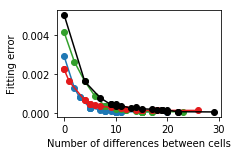

In [17]:
cm2inch = 1/2.54
plt.figure(figsize=((3/2)*5*cm2inch, 5*cm2inch))
plt.plot(df_braf.N_diff, df_braf.error,"o-", color = col_dict["braf_wt"]) #, label = "Braf & WT")
plt.plot(df_ras.N_diff,  df_ras.error, "o-", color = col_dict["ras_wt"])# ,  label = "Ras & WT")
plt.plot(df_egfr.N_diff, df_egfr.error,"o-", color = col_dict["egfr_wt"])# , label = "EGFR & WT")
plt.plot(df_all.N_diff,  df_all.error, "o-", color = "black")
plt.xlabel('Number of differences between cells')
plt.ylabel('Fitting error')
plt.show()

## Scan over theta with the addition of noise

In [18]:
random.seed(29121982)

rglob_dict = {
    'wt': utils.add_noise(rglob_wt, 0.1), 
    'ras': utils.add_noise(rglob_ras, 0.1),
    'braf':utils.add_noise(rglob_braf, 0.1),
    'egfr': utils.add_noise(rglob_egfr, 0.1)
}

panel_all = cnr.PerturbationPanel(
    REF_NODES, PERTURBATIONS, INHIBITOR_TARGETS, [], rglob_dict
)


# Panels with mutant + wt
panel_ras_wt = cnr.PerturbationPanel(
    REF_NODES, PERTURBATIONS, INHIBITOR_TARGETS, [], 
    {key: val for key, val in rglob_dict.items() if key in {'wt', 'ras'}} 
)

panel_braf_wt = cnr.PerturbationPanel(
    REF_NODES, PERTURBATIONS, INHIBITOR_TARGETS, [],
    {key: val for key, val in rglob_dict.items() if key in {'wt', 'braf'}} 
)
panel_egfr_wt = cnr.PerturbationPanel(
    REF_NODES, PERTURBATIONS, INHIBITOR_TARGETS, [],
    {key: val for key, val in rglob_dict.items() if key in {'wt', 'egfr'}} 
)

In [19]:
%%capture
sols_ras_wt_theta  = scan_theta(panel_ras_wt,  THETA_VALS, eta = ETA, bounds=BOUNDS, use_previous=True)
sols_braf_wt_theta = scan_theta(panel_braf_wt, THETA_VALS, eta = ETA, bounds=BOUNDS, use_previous=True)
sols_egfr_wt_theta = scan_theta(panel_egfr_wt, THETA_VALS, eta = ETA, bounds=BOUNDS, use_previous=True)
sols_all_theta     = scan_theta(panel_all,     THETA_VALS, eta = ETA, bounds=BOUNDS, use_previous=True)

In [22]:
def extract_theta_scan_results(sol_lst):
    df = pd.DataFrame([
        (sol.meta_info['theta'], 
         len(sol.deviations_overview().index),
         sol.mssr, 
         sol.imap.sum().sum(),
         fpr(sol.imap, REF_IMAP),
         tpr(sol.imap, REF_IMAP),
         sol.objective_value                 
        ) for sol in sol_lst],
        columns = ["theta", "N_diff", "error", "N_edge", "FPR", "TPR", "obj_val"] 
    )
    return df
df_ras  = extract_theta_scan_results(sols_ras_wt_theta)
df_ras['panel'] = "ras_wt_theta"
df_braf = extract_theta_scan_results(sols_braf_wt_theta)
df_braf['panel'] = "braf_wt_theta"
df_egfr = extract_theta_scan_results(sols_egfr_wt_theta)
df_egfr['panel'] = 'egfr_wt_theta'
df_all  = extract_theta_scan_results(sols_all_theta)
df_all['panel'] = 'all_theta'

df = pd.concat([df_braf, df_ras, df_egfr, df_all])
# df.to_csv("../results/solutions/scan-theta-noise=0.1.tsv", sep = "\t", index = False)

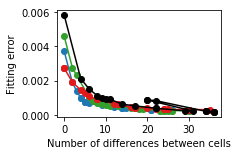

In [23]:
cm2inch = 1/2.54
plt.figure(figsize=((3/2)*5*cm2inch, 5*cm2inch))
plt.plot(df_braf.N_diff, df_braf.error,"o-", color = col_dict["braf_wt"]) #, label = "Braf & WT")
plt.plot(df_ras.N_diff,  df_ras.error, "o-", color = col_dict["ras_wt"])# ,  label = "Ras & WT")
plt.plot(df_egfr.N_diff, df_egfr.error,"o-", color = col_dict["egfr_wt"])# , label = "EGFR & WT")
plt.plot(df_all.N_diff,  df_all.error, "o-", color = "black")
plt.xlabel('Number of differences between cells')
plt.ylabel('Fitting error')
plt.show()